<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/07_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Functions

In [1]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

In [53]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.   

In [3]:
def nll(y_true, y_pred):
  """ Negative log likelihood (Bernoulli). """

  # keras.losses.binary_crossentropy gives the mean
  # over the last axis. we require the sum
  return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):

  """ Identity transform layer that adds KL divergence
  to the final model loss.
  """

  def __init__(self, *args, **kwargs):
    self.is_placeholder = True
    super(KLDivergenceLayer, self).__init__(*args, **kwargs)

  def call(self, inputs):
    mu, log_var = inputs
    kl_batch = - .5 * K.sum(1 + log_var -
                            K.square(mu) -
                            K.exp(log_var), axis=-1)
    self.add_loss(K.mean(kl_batch), inputs=inputs)

    return inputs

In [6]:
!wget https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 -O inception_score_mnist.h5
inception_score_model = keras.models.load_model('./inception_score_mnist.h5')

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from keras.datasets import mnist
from PIL import Image as pil_image


def inception_score(x, resizer=None, batch_size=32, denorm_im=1):
    r = None
    n_batch = (x.shape[0]+batch_size-1) // batch_size
    for j in range(n_batch):
        x_batch = x[j*batch_size:(j+1)*batch_size, :, :, :]
        if denorm_im:
          x_batch = (x_batch + 1)/2
        r_batch = inception_score_model.predict(x_batch) # r has the probabilities for all classes
        r = r_batch if r is None else np.concatenate([r, r_batch], axis=0)
    p_y = np.mean(r, axis=0) # p(y)
    e = r*np.log(r/p_y) # p(y|x)log(P(y|x)/P(y))
    e = np.sum(e, axis=1) # KL(x) = Σ_y p(y|x)log(P(y|x)/P(y))
    e = np.mean(e, axis=0)
    return np.exp(e) # Inception score


def image_inception_score(generator, n_ex=10000, dim_random=10, input_noise=None, denorm_im=1):
    if input_noise is None:
      input_noise = np.random.normal(0,1,size=[n_ex,dim_random])
    x_pred = generator.predict(input_noise)
    if len(x_pred.shape)==2:
      x_pred = x_pred.reshape(n_ex, 28, 28, 1)
    return inception_score(x_pred, denorm_im=denorm_im)

--2023-03-11 17:46:26--  https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 74.112.186.144
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 [following]
--2023-03-11 17:46:26--  https://imperialcollegelondon.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 [following]
--2023-03-11 17:46:27--  https://imperialcollegelondon.app.box.com/public/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5
Resolving imperialcollegelondon.app.box.com (imperialcollegelondon.app.box.com).

Instructions for updating:
Colocations handled automatically by placer.


In [44]:
def plot_loss(losses):
    plt.figure()
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.savefig('./loss.png')
    plt.close()
def plot_gen(mnist=1, n_ex=16, dim=(4,4), figsize=(10,10)):
    noise = np.random.normal(0,1,size=[n_ex,randomDim])
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        if mnist:
          img = generated_images[i,:,:,0]
          plt.imshow(img, cmap='gray')
        else:
          img = generated_images[i,:,:,:]
          plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images.png')
    plt.close()

def train_epoch(gan, generator, discriminator, plt_frq=25, BATCH_SIZE=32, mnist=1):  
  vector_ind = np.random.permutation(x_train.shape[0])
  nb_epoch = int(x_train.shape[0]/BATCH_SIZE)
  pbar = tqdm_notebook(range(nb_epoch))
  for e in range(nb_epoch):  
    ind = vector_ind[e*BATCH_SIZE:(e+1)*BATCH_SIZE]
    # Make generative images
    image_batch = x_train[ind,:,:,:]    
    noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    generated_images = generator.predict(noise_gen)
    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*BATCH_SIZE])
    y[0:BATCH_SIZE] = 1
    y[BATCH_SIZE:] = 0

    #make_trainable(discriminator,True)
    d_loss  = discriminator.train_on_batch(X,y)
    losses["d"].append(d_loss)
    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    y2 = np.zeros([BATCH_SIZE])
    y2[:] = 1

    #make_trainable(discriminator,False)
    g_loss = gan.train_on_batch(noise_tr, y2 )
    losses["g"].append(g_loss)

    # Updates plots. This is a little bit of a mess due to how the notebook
    # handles the outputs
    if e % plt_frq==plt_frq-1:
      plot_loss(losses)
      plot_gen(mnist)
      fig, ax = plt.subplots(2,1, figsize=(20,10) )
      img=mpimg.imread('loss.png')
      ax[0].imshow(img)
      ax[0].axis('off')
      img=mpimg.imread('images.png')
      ax[1].imshow(img)
      ax[1].axis('off')
      plt.tight_layout()
      display.clear_output(wait=True)
      pbar.update(plt_frq)
      display.display(pbar)
      display.display(fig)
      plt.close()


# Task 1

### Latent dimension = 2

In [54]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 2
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 198us/sample - loss: 173.4373 - val_loss: 161.7671
Epoch 2/20
60000/60000 [==============================] - 11s 178us/sample - loss: 159.8242 - val_loss: 158.1459
Epoch 3/20
60000/60000 [==============================] - 13s 210us/sample - loss: 157.2459 - val_loss: 156.1365
Epoch 4/20
60000/60000 [==============================] - 12s 199us/sample - loss: 155.8792 - val_loss: 154.3163
Epoch 5/20
60000/60000 [==============================] - 10s 163us/sample - loss: 154.7144 - val_loss: 154.1941
Epoch 6/20
60000/60000 [==============================] - 10s 172us/sample - loss: 154.0252 - val_loss: 154.0694
Epoch 7/20
60000/60000 [==============================] - 10s 169us/sample - loss: 153.2561 - val_loss: 152.7092
Epoch 8/20
60000/60000 [==============================] - 10s 167us/sample - loss: 152.8116 - val_loss: 152.7112
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0417


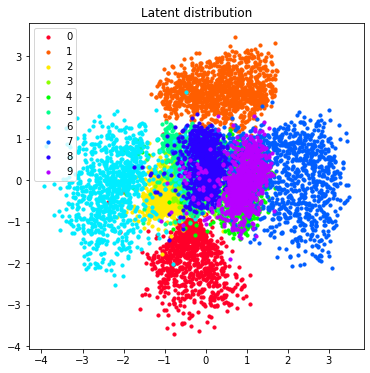

In [55]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [57]:
image_inception_score(decoder, dim_random=2, denorm_im=0)

5.7242537

## Latent dimension = 4

In [58]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 4
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 15s 242us/sample - loss: 149.5208 - val_loss: 136.2776
Epoch 2/20
60000/60000 [==============================] - 12s 201us/sample - loss: 134.9310 - val_loss: 134.9594
Epoch 3/20
60000/60000 [==============================] - 10s 166us/sample - loss: 132.9675 - val_loss: 133.1372
Epoch 4/20
60000/60000 [==============================] - 10s 172us/sample - loss: 131.7807 - val_loss: 132.4116
Epoch 5/20
60000/60000 [==============================] - 10s 165us/sample - loss: 130.9318 - val_loss: 131.2946
Epoch 6/20
60000/60000 [==============================] - 10s 161us/sample - loss: 130.2776 - val_loss: 130.5833
Epoch 7/20
60000/60000 [==============================] - 10s 166us/sample - loss: 129.7134 - val_loss: 130.2807
Epoch 8/20
60000/60000 [==============================] - 10s 171us/sample - loss: 129.2517 - val_loss: 129.8111
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0284


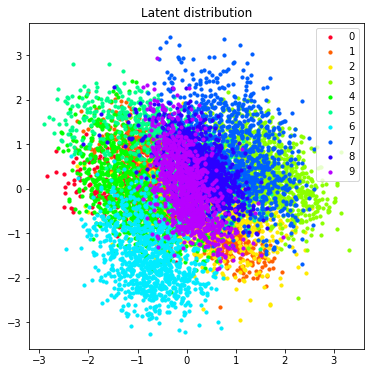

In [59]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [60]:
image_inception_score(decoder, dim_random=4, denorm_im=0)

7.4154243

## 6


In [61]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 6
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 194us/sample - loss: 137.5589 - val_loss: 122.2261
Epoch 2/20
60000/60000 [==============================] - 10s 166us/sample - loss: 121.0929 - val_loss: 118.5522
Epoch 3/20
60000/60000 [==============================] - 10s 168us/sample - loss: 118.5246 - val_loss: 117.1297
Epoch 4/20
60000/60000 [==============================] - 10s 173us/sample - loss: 117.1589 - val_loss: 116.9493
Epoch 5/20
60000/60000 [==============================] - 10s 164us/sample - loss: 116.2397 - val_loss: 115.6206
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 115.4526 - val_loss: 114.7340
Epoch 7/20
60000/60000 [==============================] - 10s 167us/sample - loss: 114.8234 - val_loss: 114.4273
Epoch 8/20
60000/60000 [==============================] - 10s 172us/sample - loss: 114.2778 - val_loss: 115.1697
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0197


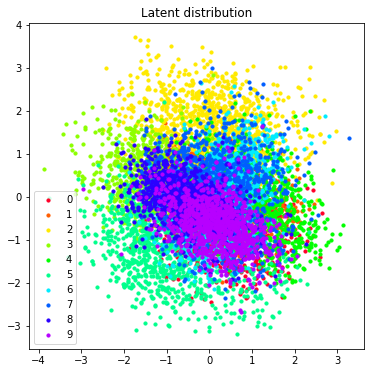

In [62]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [63]:
image_inception_score(decoder, dim_random=6, denorm_im=0)

7.4690957

## 8

In [64]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 8
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 12s 198us/sample - loss: 130.1456 - val_loss: 114.2171
Epoch 2/20
60000/60000 [==============================] - 10s 168us/sample - loss: 113.3020 - val_loss: 110.7651
Epoch 3/20
60000/60000 [==============================] - 11s 175us/sample - loss: 110.7941 - val_loss: 109.5215
Epoch 4/20
60000/60000 [==============================] - 10s 168us/sample - loss: 109.4886 - val_loss: 109.0877
Epoch 5/20
60000/60000 [==============================] - 10s 163us/sample - loss: 108.5622 - val_loss: 107.4959
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 107.8481 - val_loss: 106.9461
Epoch 7/20
60000/60000 [==============================] - 10s 174us/sample - loss: 107.2910 - val_loss: 106.6790
Epoch 8/20
60000/60000 [==============================] - 10s 169us/sample - loss: 106.8285 - val_loss: 106.1997
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0146


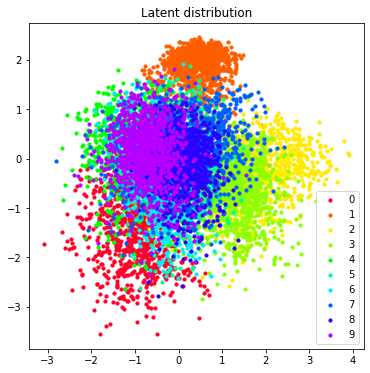

In [65]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [66]:
image_inception_score(decoder, dim_random=8, denorm_im=0)

7.444928

## 10

In [40]:
import tensorflow as tf
# TF 2.0 broke this code, so we have to add this line
tf.compat.v1.disable_eager_execution()

## Encoder
# LeakyReLU are used in GANs generator as are usually
# beneficial. We use it also in the VAE architecture 
# to match the GAN architecture, but ReLU works too.

latent_dim = 10
x = tf.keras.Input(shape=(original_dim,))
h = Reshape((28, 28, 1))(x)
h = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same')(h)
h = LeakyReLU(0.2)(h)
h = Flatten()(h)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = tf.keras.Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

decoder = Sequential()
decoder.add(Dense(128*7*7, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
decoder.add(LeakyReLU(0.2))
decoder.add(Reshape((7, 7, 128)))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
decoder.add(LeakyReLU(0.2))
decoder.add(UpSampling2D(size=(2, 2)))
decoder.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='sigmoid'))
decoder.add(Flatten())
x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='adam', loss=nll)

epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 191us/sample - loss: 126.3441 - val_loss: 110.1940
Epoch 2/20
60000/60000 [==============================] - 11s 178us/sample - loss: 108.5453 - val_loss: 106.7025
Epoch 3/20
60000/60000 [==============================] - 10s 165us/sample - loss: 106.0918 - val_loss: 104.5127
Epoch 4/20
60000/60000 [==============================] - 10s 165us/sample - loss: 104.7584 - val_loss: 103.5894
Epoch 5/20
60000/60000 [==============================] - 10s 166us/sample - loss: 103.8440 - val_loss: 103.3406
Epoch 6/20
60000/60000 [==============================] - 10s 167us/sample - loss: 103.1646 - val_loss: 103.3141
Epoch 7/20
60000/60000 [==============================] - 10s 169us/sample - loss: 102.6822 - val_loss: 102.5798
Epoch 8/20
60000/60000 [==============================] - 10s 161us/sample - loss: 102.2816 - val_loss: 102.0962
Epoch 9/20
60000/60000 [======================

The MSE is: 0.0119


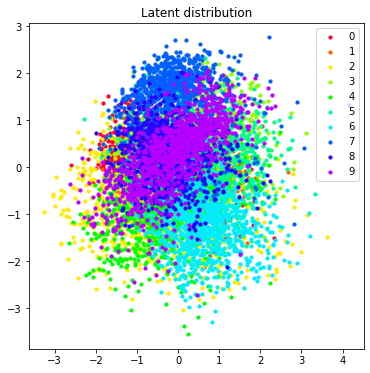

In [41]:
encoder = Model(x, z_mu)
z_test = encoder.predict(x_test, batch_size=batch_size)
images = decoder.predict(z_test)
print("The MSE is: {:.4f}".format(((images-x_test)**2).mean()))

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(figsize=(6,6))
cm = plt.get_cmap('gist_rainbow')
ax.set_prop_cycle(color=[cm(1.*i/(10)) for i in range(10)])
for l in range(10):
    # Only select indices for corresponding label
    ind = y_test == l
    ax.scatter(z_test[ind, 0], z_test[ind, 1], label=str(l),s=10)
ax.legend()
plt.title("Latent distribution")
plt.show()

In [42]:
image_inception_score(decoder, dim_random=10, denorm_im=0)

7.3778315

## GAN

In [45]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 5
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 6272)              37632     
                                                                 
 leaky_re_lu_44 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_22 (Reshape)        (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_22 (UpSamplin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 14, 14, 64)        204864    
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                     

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_46 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_47 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_22 (Flatten)        (None, 6272)            

In [46]:
# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 5)]               0         
                                                                 
 sequential_11 (Sequential)  (None, 28, 28, 1)         244097    
                                                                 
 sequential_12 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 456,962
Trainable params: 244,097
Non-trainable params: 212,865
_________________________________________________________________


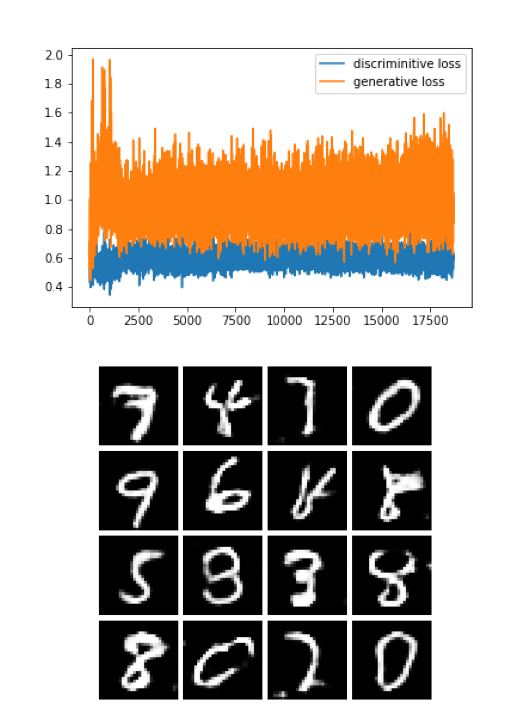

In [47]:
# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

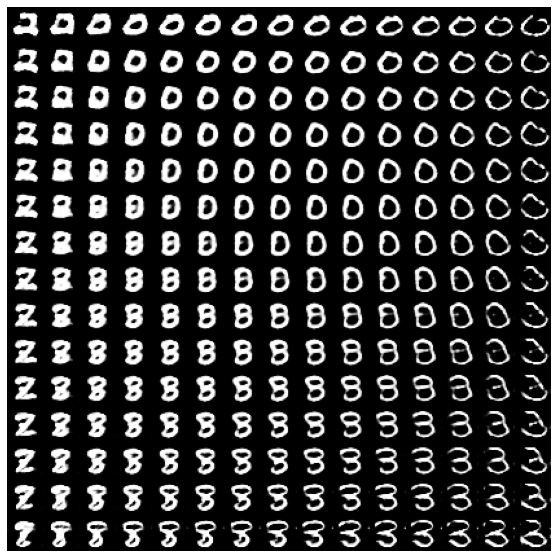

In [48]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [50]:
image_inception_score(generator, dim_random=5, denorm_im=1)

8.21912

## 6

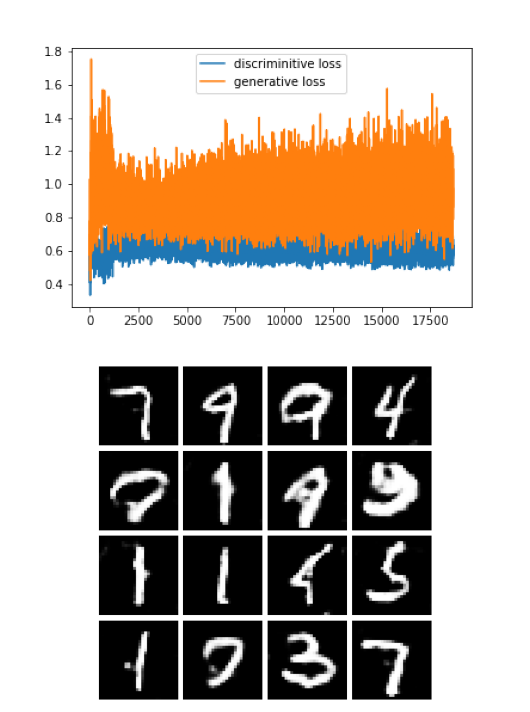

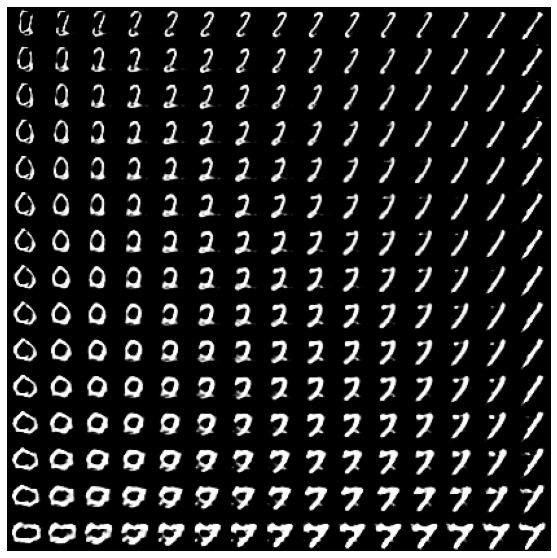

In [72]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 6
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [73]:
image_inception_score(generator, dim_random=6, denorm_im=1)

8.106026

## 7

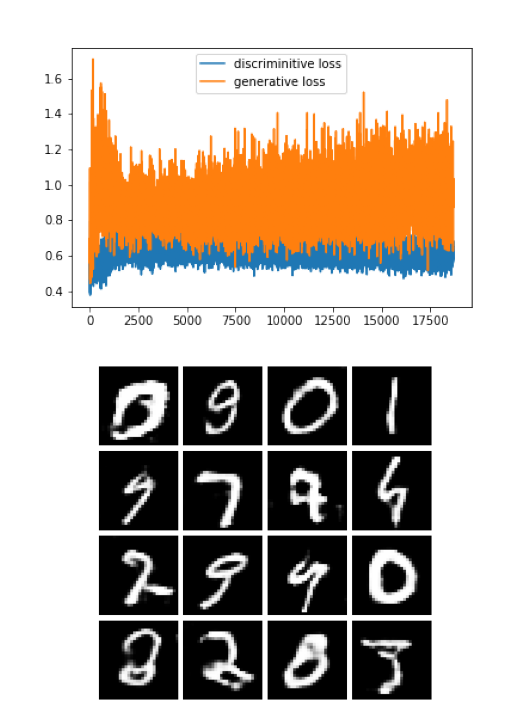

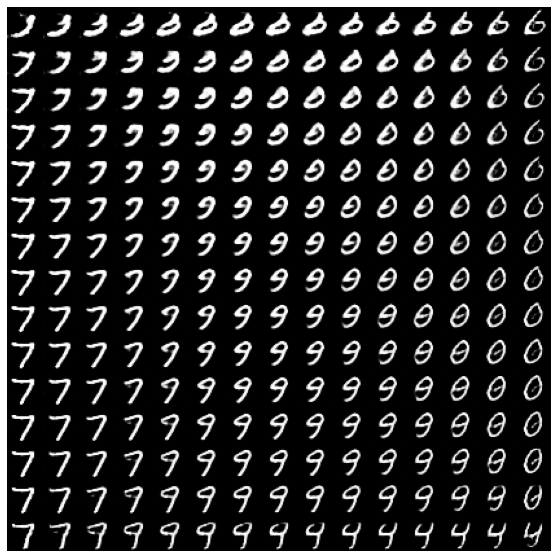

In [74]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 7
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [75]:
image_inception_score(generator, dim_random=7, denorm_im=1)


8.132663

## 8

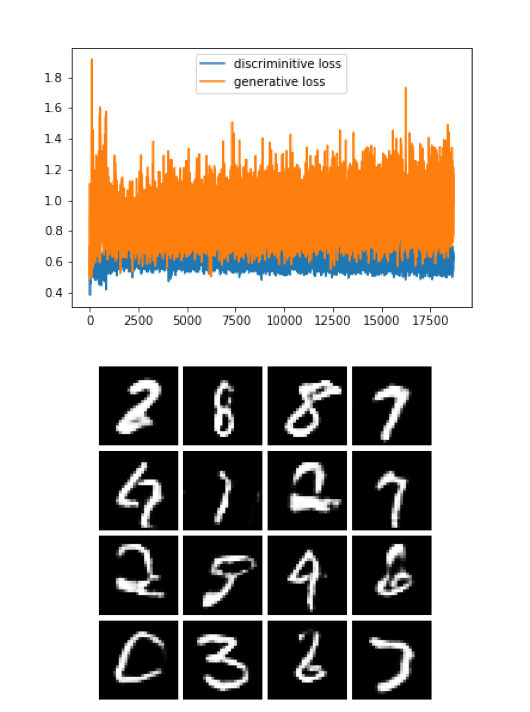

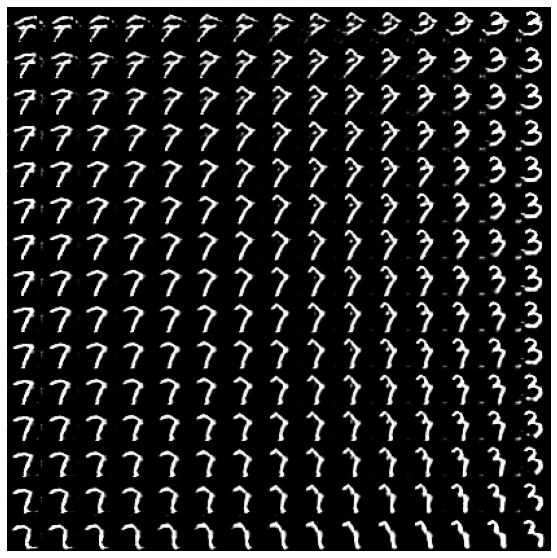

In [76]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 8
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [77]:
image_inception_score(generator, dim_random=8, denorm_im=1)

8.273274

## 9

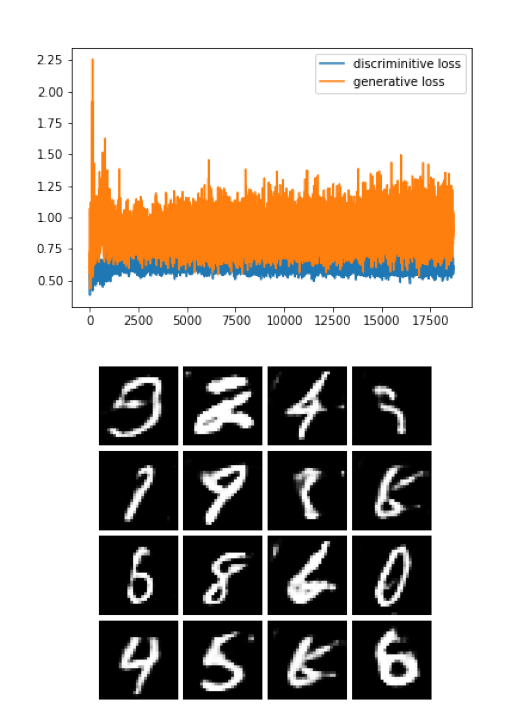

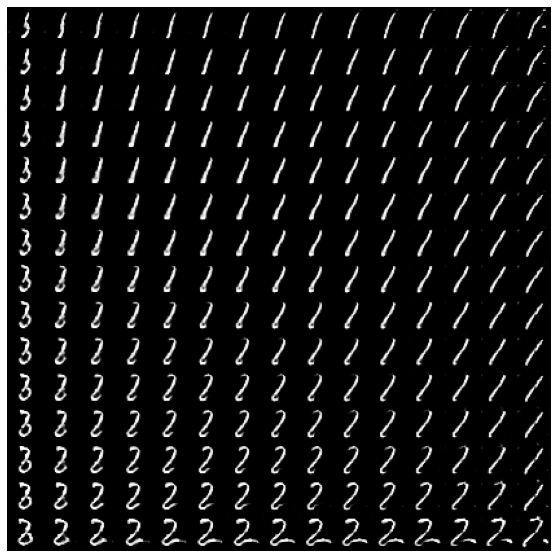

In [78]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 9
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [79]:
image_inception_score(generator, dim_random=9, denorm_im=1)


8.300297

## 10

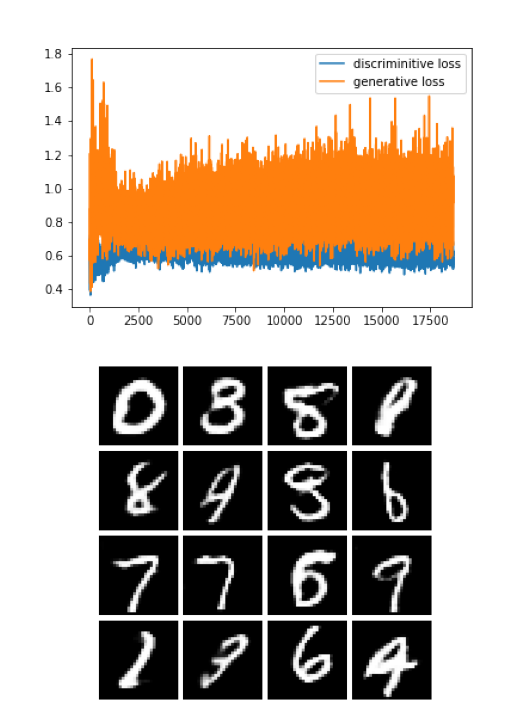

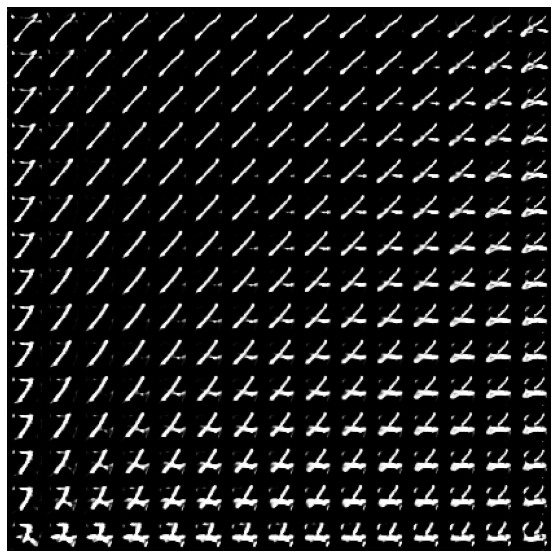

In [83]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.  

# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 10
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 10
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

In [84]:
image_inception_score(generator, dim_random=10, denorm_im=1)


8.202063

# Task 2

In [85]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

def showColored_two_models_Ims(imB, fake_imA_MAE, fake_imA_cGAN, real_imA):
  
  plt.subplot(141)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('BW', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(142)
  plt.imshow(np.clip(fake_imA_MAE[0], 0, 1)) 
  plt.title('MAE', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(143)
  plt.imshow(np.clip(fake_imA_cGAN[0], 0, 1))
  plt.title('cGAN', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(144)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

In [86]:
# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 1))

# Build the generator
generator_mae = build_generator(im_shape)
fake_A = generator_mae(img_B)
generator_mae = Model(inputs=img_B, outputs=fake_A)
generator_mae.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])

num_epochs = 1
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
    
    # -----------------
    #  Train Generator (MAE)
    # -----------------
    g_loss = generator_mae.train_on_batch(imgs_B, imgs_A)
    g_avg_loss.append(g_loss[0])

    fake_A = generator_mae.predict(imgs_B)  

    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      
    
    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator_mae.save('generator_mae.h5') 

NameError: ignored